# Tensorflow 2 / Keras Tutorial

* Tensorflow allows you to perform tensor calculations
* great benefits:
    * automatic differentiation
    * move data to GPU -> faster calculation for large amounts of data

## First steps
Install tensorflow (CPU-only): `pip install tensorflow`

or for GPU (requires CUDA >= 10.0): `pip tensorflow-gpu`

In [1]:
import tensorflow as tf
import numpy as np

## Tensors

Tensors can be created in a number of ways:

* from numpy arrays
* from lists
* using tensorflow functions
    * e.g. `tf.ones`, `tf.zeros`, ...
    * also, calculation functions convert to tf tensors automatically: `tf.add`, ...

In [2]:
import numpy as np
import tensorflow as tf

# create a numpy array
a = np.array([1,2,3])
print(f"type of a: {type(a)}")

# create tensor of zeros
b = tf.zeros((3,))
print(f"type of b: {type(b)}")

# automatic conversion to tensor
c = tf.add(a,b)
print(f"type of c: {type(c)}")

# print contents
print(c)

type of a: <class 'numpy.ndarray'>
type of b: <class 'tensorflow.python.framework.ops.EagerTensor'>
type of c: <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32)


Now the cool stuff - automatic differentiation!
To tell tensorflow to record changes to variables, you need a `GradientTape`.
It records the changes to variables "on a tape".
This tape can then be queried for gradients.

Let's differentiate $y = x*2 + z$ w.r.t $x, z \in \mathbb{R}^3$

In [3]:
x = tf.ones((3,))
z = tf.ones((3,))

with tf.GradientTape(persistent=True) as t:
    t.watch((x,z))
    y = x*2 + z
    print("y", y)
print(f"dy/dx = {t.gradient(y,x)}, dy/dz = {t.gradient(y,z)}")

y tf.Tensor([3. 3. 3.], shape=(3,), dtype=float32)
dy/dx = [2. 2. 2.], dy/dz = [1. 1. 1.]


That is the first step on getting a trainable model - now that we can calculate gradients,
we can try building and training our first linear layers - with one tensor for the weights and one for the bias.

Tensors are, however, immutable - we actually want to adapt our weights by gradient descent over time.
This is where *Variables* come in. They are essentially mutable tensors.

In [4]:
# create tensor of ones
x = tf.Variable(tf.ones((3,)))
print(x)

# add tensor of ones, thereby changing the state of x
x.assign_add(tf.ones((3,)))
print(x)

<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([1., 1., 1.], dtype=float32)>
<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([2., 2., 2.], dtype=float32)>


Now we have everything to build our own linear layer with sigmoid activation

$f(\mathbf{x}) = \sigma(\mathbf{W}\mathbf{x} + \mathbf{b})$

and a square loss function

$loss(y,\hat{y}) = (y-\hat{y})^2$

In [5]:
def se_loss(y_hat, y):
    loss = tf.square(y_hat-y)  # (y^ - y)^2
    return loss

class Perceptron:
    def __init__(self, in_size: int, out_size: int):
        # randomly initialize weights
        self.W = tf.Variable(np.random.sample((out_size, in_size)), dtype=tf.float32)  # insize x outsize
        self.b = tf.Variable(np.random.sample((out_size, 1)), dtype=tf.float32)        # outsize
        self.activation = tf.sigmoid
        print(f"shape of W: {self.W.shape}")
        print(f"shape of b: {self.b.shape}")
        
    def __call__(self, x):
        # forward pass 
        Wx = tf.matmul(self.W, x)
        z = tf.add(Wx, self.b)
        y = self.activation(z)
        return y
    
    
def loss_and_grads(model, x, y, print_stuff=False):
    with tf.GradientTape() as t:
        y_hat = model(x)
        loss = se_loss(y_hat, y)
        
        dW, db = t.gradient(loss, [model.W, model.b])
    if print_stuff:
        print("forward pass: sigmoid(Wx + b) = ", y_hat)
        print("loss: ", loss)
        print("backward pass:")
        print("dloss/dW = ", dW)
        print("dloss/db = ", db)
    return y_hat, loss, (dW, db)
    

l = Perceptron(in_size=4, out_size=1)
x = tf.ones([4,1])
y = tf.ones([1,])
y_hat, loss, t = loss_and_grads(l, x, y, print_stuff=True)

shape of W: (1, 4)
shape of b: (1, 1)
forward pass: sigmoid(Wx + b) =  tf.Tensor([[0.9144302]], shape=(1, 1), dtype=float32)
loss:  tf.Tensor([[0.00732219]], shape=(1, 1), dtype=float32)
backward pass:
dloss/dW =  tf.Tensor([[-0.01339126 -0.01339126 -0.01339126 -0.01339126]], shape=(1, 4), dtype=float32)
dloss/db =  tf.Tensor([[-0.01339126]], shape=(1, 1), dtype=float32)


## Training your first neural network

**Our problem:** 
Ever since Grumpy Cat became internet famous, he has been put on millions of memes.
As you can imagine, there is a huge amount of requests for him to judge events as being either nice or horrible.
Grumpy Cat is sick of dealing with each request manually and wants us to build a very sophisticated classifier for this task using neural networks (being a lot on the internet, Grumpy Cat knows what the latest hype is about).

<img src="https://i2.wp.com/metro.co.uk/wp-content/uploads/2019/05/SEI_67888770.jpg?quality=90&strip=all&zoom=1&resize=540%2C405&ssl=1"/>
(https://i2.wp.com/metro.co.uk/wp-content/uploads/2019/05/SEI_67888770.jpg?quality=90&strip=all&zoom=1&resize=540%2C405&ssl=1)

So we ask Grumpy Cat for some example data points in the form of $(x,y)$. 
x refers to Grumpy Cat's observations, y to his rating.

where x = (
           # mondays in sentence, 
           # references to a movie, 
           grumy cat had breakfast (0 or 1), 
           # humans grumpy cat has seen today
           )
and $y = 0$ if nice, $y=1$ if horrible.

Grumpy cat then concatenates all samples into a dataset $(X,Y)$:
$X \in \mathbb{R}^{n \times 4}, Y \in \mathbb{R}^{n \times 1} $

In [15]:
num_samples = 1000

num_mondays = np.random.randint(low=0, high=10, size=(num_samples,))
num_references = np.random.randint(low=0, high=10, size=(num_samples,))
had_breakfast = np.random.randint(low=0, high=2, size=(num_samples,))
num_humans = np.random.randint(low=0, high=50, size=(num_samples,))

# create X by concatenating features column-wise
X = np.stack([num_mondays, num_references, had_breakfast, num_humans], axis=1)
print("X shape:", X.shape)
for i in range(5):
    print(f"mondays: {X[i,0]}, movies: {X[i,1]}, breakfast: {bool(X[i,2])}, humans: {X[i,3]}")
    
# create Y:
Y = np.random.randint(low=1, high=2, size=(num_samples, )) # everything is horrible!
print("Y shape: ", Y.shape)

X shape: (1000, 4)
mondays: 3, movies: 7, breakfast: True, humans: 20
mondays: 2, movies: 4, breakfast: True, humans: 3
mondays: 2, movies: 2, breakfast: True, humans: 35
mondays: 5, movies: 4, breakfast: True, humans: 10
mondays: 8, movies: 3, breakfast: False, humans: 48
Y shape:  (1000,)


shape of W: (1, 4)
shape of b: (1, 1)
initial bias: <tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[0.8129599]], dtype=float32)>
intial weights: <tf.Variable 'Variable:0' shape=(1, 4) dtype=float32, numpy=array([[0.46954912, 0.03254253, 0.81848973, 0.653151  ]], dtype=float32)>
epoch 0 loss: 7.480580825358629e-05
epoch 1 loss: 3.72356444131583e-05
epoch 2 loss: 2.7693928132066503e-05
epoch 3 loss: 2.2479029212263413e-05
epoch 4 loss: 1.9105786122963764e-05
trained bias <tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[0.97682923]], dtype=float32)>
trained weights <tf.Variable 'Variable:0' shape=(1, 4) dtype=float32, numpy=array([[0.5604065 , 0.37618437, 0.84506536, 0.8208848 ]], dtype=float32)>


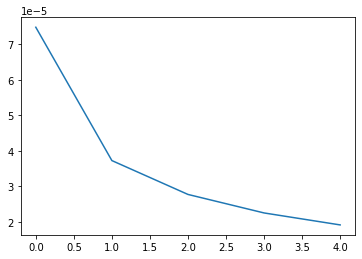

In [16]:
import matplotlib.pyplot as plt
import random

alpha = 0.5 # learning rate
perceptron = Perceptron(in_size=4, out_size=1)
print("initial bias:", perceptron.b)
print("intial weights:", perceptron.W)

losses = []
for epoch in range(5):
    epoch_loss = []
    shuffled_indices = list(range(X.shape[0]))
    random.shuffle(shuffled_indices)
    for i in shuffled_indices:
        # forward & backward pass (just draw random x, try to map all inputs to 1)
        x = tf.convert_to_tensor(X[i,:].reshape(4,1), dtype=tf.float32)
        y = tf.convert_to_tensor(Y[i], dtype=tf.float32)
        
        y_hat, loss, (dW, db) = loss_and_grads(perceptron, x, y)

        # apply gradients from backward pass
        perceptron.W.assign_sub(alpha * dW)
        perceptron.b.assign_sub(alpha * db)

        epoch_loss.append(loss[0,0])
    print(f"epoch {epoch} loss: {sum(epoch_loss) / len(epoch_loss)}")
    losses.append(sum(epoch_loss) / len(epoch_loss))

plt.plot(losses)
print("trained bias", perceptron.b)
print("trained weights", perceptron.W)

Let's try some predictions (remember: 0 is nice, 1 is grumpy):

In [18]:
def predict(x):
    y_hat = perceptron(x)
    return y_hat
    
print(predict([[10.],[10.],[0.],[10.]]))
print(predict([[5.],[3.],[1.],[8.]]))
print(predict([[2.],[5.],[0.],[4.]]))

tf.Tensor([[1.]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9999956]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.9992988]], shape=(1, 1), dtype=float32)


We present our model to grumpy cat, and, suprisingly, he thinks we did a woeful job.

<img width="450px" src="https://pm1.narvii.com/5788/b89a6d573c478bd8c4c17328ab101c8a08f4e84e_hq.jpg"/>
(https://pm1.narvii.com/5788/b89a6d573c478bd8c4c17328ab101c8a08f4e84e_hq.jpg")


According to him, our approach is flawed in multiple ways:
* potentially unstable (fixed learning rate, no averaging across multiple samples - high gradient variance)
* inefficient (no batching)


As is customary with cats, grumpy changed his mind - he now wants us to do multi-class classification: $y \in \{$ nice, bad, very bad $\}$!


Also, Grumpy recently heard of "deep" learning and is afraid that our model is too shallow to be trendy anymore.


**Phew, that would be a large amount of work to modify our model!**

Keras to the rescue!

Let's first re-build our current Model with Keras.

We will make use of the following functionallity
* tf.keras.Sequential module: a list of network layers
* tf.keras.layers.Dense: a linear layer with activation of your choosing
* compile(): create your model with optimizer and loss function
* fit(): train on input data and labels for the specified amount of epochs
* history: keras records training statistics for us

Epoch 1/5
1000/1000 [==============================] - 1s 511us/step - loss: 2.8486e-04
Epoch 2/5
1000/1000 [==============================] - 1s 533us/step - loss: 5.6463e-05
Epoch 3/5
1000/1000 [==============================] - 1s 552us/step - loss: 4.0761e-05
Epoch 4/5
1000/1000 [==============================] - 1s 562us/step - loss: 3.2285e-05
Epoch 5/5
1000/1000 [==============================] - 1s 537us/step - loss: 2.6836e-05


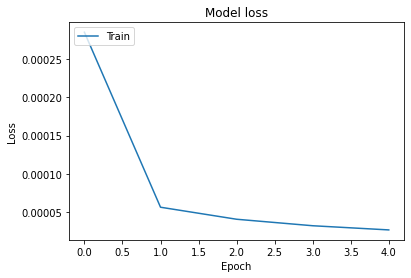

In [19]:
import tensorflow as tf
import tensorflow.keras as keras


perceptron = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation="sigmoid")
])
perceptron.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.5),
              loss=keras.losses.MeanSquaredError())
train_history = perceptron.fit(X, Y, epochs=5, batch_size=1)

# Plot training loss values
plt.plot(train_history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

We can improve stability & performance by batching (processing multiple data points at the same time -> averaging  the gradients across one mini-batch instead of one sample -> stability).

That means, we append a batch dimension ($b \in \mathbb{N}^{+}$) to our tensors:
    
$x \in \mathbb{R}^4 \rightarrow x \in \mathbb{R}^{b \times 4}$ 

and

$y \in \mathbb{R} \rightarrow y \in \mathbb{R}^{b \times 1}$

In Keras, we can specify the batch size simply by appending it to the fit() arguments.

Epoch 1/5
32/32 [==============================] - 0s 593us/step - loss: 0.0296
Epoch 2/5
32/32 [==============================] - 0s 622us/step - loss: 8.1958e-04
Epoch 3/5
32/32 [==============================] - 0s 694us/step - loss: 4.6339e-04
Epoch 4/5
32/32 [==============================] - 0s 631us/step - loss: 3.4112e-04
Epoch 5/5
32/32 [==============================] - 0s 709us/step - loss: 2.7424e-04


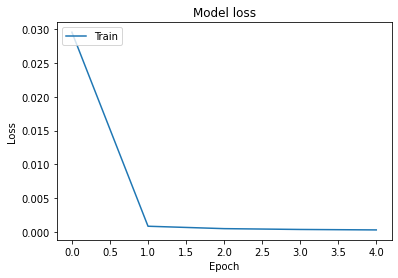

In [20]:
perceptron = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='sigmoid')
])
perceptron.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.5),
              loss=keras.losses.MeanSquaredError())
train_history = perceptron.fit(X,Y, epochs=5, batch_size=32)


# Plot training loss values
plt.plot(train_history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

Now, the last change Grumpy Cat demanded of us:
More layers and multi-class classification!

As you learned in your last excercise, we will expand the network to output 1 number per class,
apply softmax instead of sigmoid and finally swap our loss function to *CrossEntropy*.

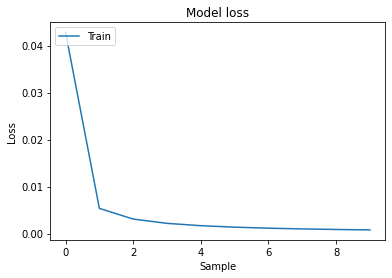

In [21]:
multiClassModel = tf.keras.Sequential([
    tf.keras.layers.Dense(3, activation='sigmoid'),
    tf.keras.layers.Dense(3, activation='softmax')
])
multiClassModel.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.5),
              loss='categorical_crossentropy')

Y_multiClass = np.zeros((X.shape[0], 3))
Y_multiClass[:,2] = 1
train_history = multiClassModel.fit(X,Y_multiClass, epochs=10, verbose=0, batch_size=16)


# Plot training loss values
plt.plot(train_history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Sample')
plt.legend(['Train'], loc='upper left')
plt.show()

We can use keras not only to train, but also to predict:

In [22]:
import tensorflow.keras as keras
import matplotlib.pyplot as plt
print(multiClassModel.predict(X[0,:].reshape(1,4)))
print(multiClassModel.predict([[5.,3.,1.,8.]]))
print(multiClassModel.predict([[2.,5.,0.,4.]]))

[[3.0954040e-04 2.9541872e-04 9.9939501e-01]]
[[3.1023033e-04 2.9606256e-04 9.9939370e-01]]
[[3.7248447e-04 3.5821964e-04 9.9926931e-01]]


To see our model architecture in more human-readable form, we can use the *summary()* function

In [23]:
print(multiClassModel.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  15        
_________________________________________________________________
dense_3 (Dense)              multiple                  12        
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
None


Best practices:
* Split your dataset into training, development and test datasets
    * train on training set
    * tune your model on development set
    * test your model on test set
        * only then do you have an estimate how well your model works on unseen data
        * **never use test set for training or tuning!**

Using a development set during training in Keras is easy:
either provide `validation_data` to the fit function or 
provide the fraction of your training set to be used as validatiton data via `validation_split` $\in [0,1)$

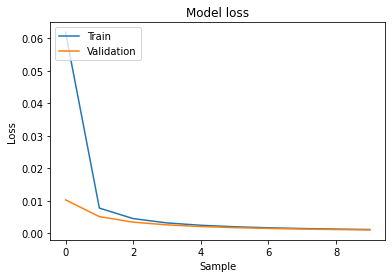

In [25]:
multiClassModel = tf.keras.Sequential([
    tf.keras.layers.Dense(3, activation='sigmoid'),
    tf.keras.layers.Dense(3, activation='softmax')
])
multiClassModel.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.5),
              loss='categorical_crossentropy')

Y_multiClass = np.zeros((X.shape[0], 3))
Y_multiClass[:,2] = 1
train_history = multiClassModel.fit(X,Y_multiClass, epochs=10, verbose=0, validation_split=0.3, batch_size=16)

# Plot training and development loss values
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Sample')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

For testing, Keras comes with the `evaluate()`-function

In [26]:
train_history = multiClassModel.evaluate(X,Y_multiClass)

32/32 [==============================] - 0s 796us/step - loss: 0.0011


For a classifier, you might also be interested in the accuracy:

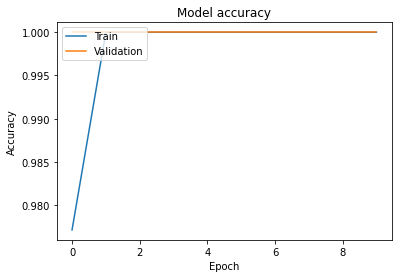

In [27]:
multiClassModel = tf.keras.Sequential([
    tf.keras.layers.Dense(3, activation='sigmoid'),
    tf.keras.layers.Dense(3, activation='softmax')
])
multiClassModel.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.5),
              loss='categorical_crossentropy', metrics=['accuracy'])

Y_multiClass = np.zeros((X.shape[0], 3))
Y_multiClass[:,2] = 1
history = multiClassModel.fit(X,Y_multiClass, epochs=10, verbose=0, validation_split=0.3, batch_size=16)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Creating custom keras models

Instead of using `keras.Sequential`, we can also write our own model class by inheriting from `keras.Model`:

In [28]:
class FancyClassifier(tf.keras.Model):
  def __init__(self):
    super(FancyClassifier, self).__init__()
    self.d1 = keras.layers.Dense(4, activation='relu')
    self.d2 = keras.layers.Dense(4, activation='relu')
    self.out = keras.layers.Dense(1, activation='sigmoid')

  def __call__(self, x):
    x = self.d1(x)
    x = self.d2(x)
    return self.out(x)
model = FancyClassifier()

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss=keras.losses.MeanSquaredError())

Training is also just calling `model.fit(...)`
You can also pass custom loss functions, etc.

If you want to evaluate your model on some test dataset
(like fit without training, but including metrics),
you can use `evaluate()`: